In [3]:
import numpy as np
import tifffile
from cellpose import models, core
import os

/opt/anaconda3/envs/unetenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def import_images(images_path,num_imgs=20):
    images = [np.squeeze(tifffile.imread(images_path + str(i) + '.tif')) for i in range(num_imgs)]
    return images

In [134]:
def get_cellpose_data(images_path, augment=False, learning_rate=0.01):
    num_imgs = 5

    #Import the images
    print('importing images')
    images = import_images(images_path,num_imgs=num_imgs)
    images = np.array(images)
    images = images
    print(images.shape)
    print(images.shape)
    print('imported images successfully')

    #Put the images through CellPose to get the cellprobs and masks
    print('getting model')
    model = models.CellposeModel(model_type='nuclei',gpu=core.use_gpu())
    print('got model')

    print('getting data')

    masks, flows, styles = model.eval(images,channels=[[0,0]],cellprob_threshold=False)

    print('got data')

    masks = np.array(masks)
    masks = np.where(masks>0,1,0)
    flows = np.array(flows)
    

    #cellprobs = [[0][i][:,:,2] for i in range(num_imgs)]
    cellprobs = np.array([flows[2][i] for i in range(num_imgs)])

    #each model needs to use the same X_train and y_train, we test them on the same data

    #First model
        #Takes original images in 256x256 crops
        #Takes the ground truth CellPose cellprobs
        #Trained

    #Second model
        #Takes the groundtruth CellPose cellprobs
        #Takes the groundtruth CellPose masks

    return images, masks, cellprobs


In [135]:
images_path = os.getcwd() + '/812_plate/'

images, masks, cellprobs = get_cellpose_data(images_path, augment=False, learning_rate=0.01)

importing images
(5, 1080, 1080, 4)
(5, 1080, 1080, 4)
imported images successfully
getting model
got model
getting data
got data
flows shape: (4,)
(5, 1080, 1080)
(4,)


/var/folders/ff/h7rcmtgd7cd83fyvtv05xp5m0000gn/T/ipykernel_9915/1783143020.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  flows = np.array(flows)


In [228]:
import random
import torch

def get_random_crops(images, masks, cellprobs):

    imgs = [(image-np.min(image))/(np.max(image)-np.min(image)) for image in images]
    masks = [(mask-np.min(mask))/(np.max(mask)-np.min(mask)) for mask in masks] #they are already 0 and 1 no need to normalise
    cellprobs = [(cellprob-np.min(cellprob))/(np.max(cellprob)-np.min(cellprob)) for cellprob in cellprobs]

    #make random crops with them
    imgs_aug = []
    mks_aug = []
    cellprob_aug = []
    for i in range(len(imgs)):
        img = imgs[i]
        mask = masks[i]
        cellprob = cellprobs[i]
        for j in range(10):
            #crop_width = random.randint(5,256)
            #crop_height = random.randint(5,256)
            #crop_val = random.randint(5,256)
            crop_val = 256
            assert img.shape[0] >= crop_val
            assert img.shape[1] >= crop_val
            assert img.shape[0] == mask.shape[0]
            assert img.shape[1] == mask.shape[1]
            x = random.randint(0, img.shape[1] - crop_val)
            y = random.randint(0, img.shape[0] - crop_val)
            img_cropped = np.array(img[y:y+crop_val, x:x+crop_val],dtype=np.float16)
            mask_cropped = mask[y:y+crop_val, x:x+crop_val]
            cellprob_cropped = cellprob[y:y+crop_val, x:x+crop_val]

            #Filters out the masks that have only background
            if len(np.unique(mask_cropped)) == 1:
                j -= 1
                continue
            
            #only allow samples where the amount of cells takes over 0.4 of the total image
            unique, counts = np.unique(mask_cropped, return_counts=True)
            #while len(counts) < 2 or (counts[1] / (counts[0]+counts[1])) < 0.4:
            
            #Not padding anymore because all the images are of the same size (128x128)
            #img_cropped = padding(img_cropped,256,256)
            #mask_cropped = padding(mask_cropped,256,256)

            img_cropped = np.expand_dims(img_cropped,-1)
            mask_cropped = np.expand_dims(mask_cropped,-1)
            cellprob_cropped = np.expand_dims(cellprob_cropped,-1)

            img_cropped = np.moveaxis(img_cropped, -1, 0)
            mask_cropped = np.moveaxis(mask_cropped,-1,0)
            cellprob_cropped = np.moveaxis(cellprob_cropped,-1,0)

            imgs_aug.append(img_cropped)
            mks_aug.append(mask_cropped)
            cellprob_aug.append(cellprob_cropped)
    
    imgs_aug = torch.tensor(imgs_aug)
    mks_aug = torch.tensor(np.array(mks_aug))
    cellprob_aug = torch.tensor(np.array(cellprob_aug))

    return imgs_aug, mks_aug, cellprob_aug

In [218]:
imgs_aug, mks_aug, cellprob_aug = get_random_crops(images[:,:,:,0],masks,cellprobs)

In [297]:
print(np.unique(imgs_aug[0]))
print(np.unique(cellprob_aug[0]))

[0.00407  0.004314 0.004345 ... 0.809    0.8467   1.      ]
[0.         0.0042099  0.00432158 ... 0.92883945 0.92895573 0.9318008 ]


In [265]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

def get_data_loaders(imgs_aug, mks_aug, cellprob_aug):
    random_state = 10

    X_train_img, X_test_img, y_train_cp, y_test_cp = train_test_split(imgs_aug, cellprob_aug, test_size=0.33, random_state=random_state)

    X_train_cp, X_test_cp, y_train_mks, y_test_mks = train_test_split(cellprob_aug, mks_aug, test_size=0.33, random_state=random_state)

    trainDS_img = [(X_train_img[i],y_train_cp[i]) for i in range(len(X_train_img))]
    testDS_img  = [(X_test_img[i],y_test_cp[i]) for i in range(len(X_test_img))]
    trainLoader_img = DataLoader(trainDS_img, shuffle=True,
	                    batch_size=5, pin_memory=True,
	                    num_workers=2)
    testLoader_img = DataLoader(testDS_img, shuffle=True,
                            batch_size=5, pin_memory=True,
                            num_workers=2)

    trainDS_cp = [(X_train_cp[i],y_train_mks[i]) for i in range(len(X_train_cp))]
    testDS_cp  = [(X_test_cp[i],y_test_mks[i]) for i in range(len(X_test_cp))]
    trainLoader_cp = DataLoader(trainDS_cp, shuffle=True,
	                    batch_size=5, pin_memory=True,
	                    num_workers=2)
    testLoader_cp = DataLoader(testDS_cp, shuffle=True,
                            batch_size=5, pin_memory=True,
                            num_workers=2)

    return trainLoader_img, testLoader_img, trainLoader_cp, testLoader_cp

In [266]:
trainLoader_img, testLoader_img, trainLoader_cp, testLoader_cp = get_data_loaders(imgs_aug, mks_aug, cellprob_aug)

In [267]:
print(len(trainLoader_img))

67


In [306]:
import train_network
from u_net import UNet

import importlib
importlib.reload(train_network)
from train_network import train_network

In [269]:
print(np.unique(mks_aug[0]))


[0. 1.]


In [315]:

unet = UNet()
unet.to("mps")
unet = train_network(unet, trainLoader_img, testLoader_img, learning_rate=0.001, num_epochs=50,device="mps",loss="mse")

[INFO] training the network...
num epochs: 50
learning rate: 0.001
loss: mse
[INFO] EPOCH: 1/50  Train loss: 0.011677  Test loss: 0.003926  Time taken: 15s  Remaining time: 758s


KeyboardInterrupt: 

In [311]:
unet_2 = UNet()
unet_2 = train_network(unet_2, trainLoader_cp, testLoader_cp, learning_rate=0.001, num_epochs=10,device="mps",loss="BCEwithLogits")

[INFO] training the network...
num epochs: 10
learning rate: 0.001
loss: BCEwithLogits
[INFO] EPOCH: 1/10  Train loss: 0.138502  Test loss: 0.033649  Time taken: 20s  Remaining time: 182s
[INFO] EPOCH: 2/10  Train loss: 0.016242  Test loss: 0.011915  Train loss change: 0.26  Test loss change: 1.16  Time taken: 17s  Remaining time: 137s
[INFO] EPOCH: 3/10  Train loss: 0.010327  Test loss: 0.012506  Train loss change: -0.43  Test loss change: -0.61  Time taken: 15s  Remaining time: 103s
[INFO] EPOCH: 4/10  Train loss: 0.010337  Test loss: 0.008305  Train loss change: 0.94  Test loss change: -1.11  Time taken: 13s  Remaining time: 80s
[INFO] EPOCH: 5/10  Train loss: 0.008439  Test loss: 0.009510  Train loss change: -0.55  Test loss change: 0.46  Time taken: 15s  Remaining time: 75s
[INFO] EPOCH: 6/10  Train loss: 0.007607  Test loss: 0.006953  Train loss change: -0.53  Test loss change: -0.27  Time taken: 12s  Remaining time: 49s
[INFO] EPOCH: 7/10  Train loss: 0.007087  Test loss: 0.0078

In [286]:
X_train_img, X_test_img, y_train_cp, y_test_cp = train_test_split(imgs_aug, cellprob_aug, test_size=0.33, random_state=10)
X_train_cp, X_test_cp, y_train_mks, y_test_mks = train_test_split(cellprob_aug, mks_aug, test_size=0.33, random_state=10)

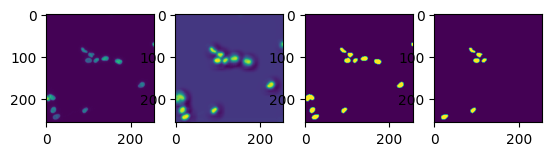

In [312]:
img_to_test = X_train_img[0]
gt_mask = y_train_mks[0]

pred_cp = unet(torch.tensor(np.expand_dims(img_to_test,0)).to("mps"))
pred_mask = unet_2(pred_cp.to("mps"))

plt.subplot(1,4,1)
plt.imshow(np.squeeze(img_to_test))
plt.subplot(1,4,2)
plt.imshow(np.squeeze(pred_cp.cpu().detach().numpy()))
plt.subplot(1,4,3)
plt.imshow(np.where(np.squeeze(pred_mask.cpu().detach().numpy())>0.5,1,0))
plt.subplot(1,4,4)
plt.imshow(np.squeeze(gt_mask))

In [314]:
img_to_test = X_test_img[0]
gt_mask = y_test_mks[0]

pred_cp = unet(torch.tensor(np.expand_dims(img_to_test,0)).to("mps"))
pred_mask = unet_2(pred_cp.to("mps"))

#plt.subplot(1,4,1)
#plt.imshow(np.squeeze(img_to_test))
#plt.subplot(1,4,2)
#plt.imshow(np.squeeze(pred_cp.cpu().detach().numpy()))
#plt.subplot(1,4,3)
#plt.imshow(np.where(np.squeeze(pred_mask.cpu().detach().numpy())>0.5,1,0))
#plt.subplot(1,4,4)
#plt.imshow(np.squeeze(gt_mask))

In [291]:
def dice_coefficient(im1,im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

In [292]:
dice_coefficient(np.where(np.squeeze(pred_mask.cpu().detach().numpy())>0.5,1,0),np.squeeze(gt_mask))

/var/folders/ff/h7rcmtgd7cd83fyvtv05xp5m0000gn/T/ipykernel_9915/2665686980.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im1 = np.asarray(im1).astype(np.bool)
/var/folders/ff/h7rcmtgd7cd83fyvtv05xp5m0000gn/T/ipykernel_9915/2665686980.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im2 = np.asarray(im2).astype(np.bool)


0.0

In [163]:
print(imgs_aug.shape)
print(len(mks_aug))
print(len(cellprob_aug))

(4987, 1, 256, 256)
4987
4987


In [159]:
print(images[:,:,:,0].shape)

(5, 1080, 1080)


In [142]:
np.unique(cellprobs[4])

array([-21.462198, -21.40873 , -21.322926, ...,  10.498028,  10.549983,
        10.553734], dtype=float32)

In [133]:
print(np.unique(flows[2][4]))

[-21.462198 -21.40873  -21.322926 ...  10.498028  10.549983  10.553734]


In [114]:
print(flows[0][0][:,:,2])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


[[[-10.557457  -10.16215   -11.116803  ... -12.405075  -11.984837
   -12.297151 ]
  [-10.818727  -10.627456  -11.269224  ... -13.130033  -12.26733
   -12.448462 ]
  [-11.555657  -10.770389  -12.519281  ... -13.678646  -12.75391
   -13.105263 ]
  ...
  [ -6.9987755  -6.920166   -6.759198  ...  -7.148648   -6.5455546
    -6.578181 ]
  [ -7.137617   -7.151311   -6.9465365 ...  -6.927557   -6.486342
    -6.40028  ]
  [ -7.325015   -7.267295   -7.24159   ...  -7.290279   -6.9033103
    -6.9693065]]

 [[ -9.034835   -8.561645   -9.515739  ... -11.87336   -10.20485
   -11.497046 ]
  [ -9.259648   -9.825378  -10.536706  ... -11.54921    -9.937924
   -11.374473 ]
  [-10.792873  -10.028882  -11.961495  ... -12.329773  -10.666711
   -10.388971 ]
  ...
  [ -7.4875255  -7.4648104  -7.4985175 ...  -5.235662   -6.765212
    -6.802374 ]
  [ -7.7312465  -7.7197504  -7.609888  ...  -5.4620805  -6.4543977
    -6.508598 ]
  [ -8.003721   -7.904077   -7.8646894 ...  -5.7253056  -6.4307995
    -6.6940327]]


In [103]:
print(cellprobs[1].shape)

(1080, 1080)


In [100]:
print(np.unique(cellprobs[0]))


[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [75]:
print(masks.shape)

(5, 1080, 1080)


In [76]:
bin_masks = np.where(masks>0,1,0)
bin

In [84]:
np.unique(bin_masks[1])
#plt.imshow(bin_masks[2])

array([0, 1])

In [50]:
print(cellprobs[0].shape)

(1080, 1080)


In [23]:
cellprobs[0][i][:,:,2]

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [10, 21, 26, ..., 27, 20,  6],
       [10, 21, 26, ..., 23, 17,  5],
       [ 4, 11, 16, ...,  7,  4,  0]], dtype=uint8)

In [24]:
cellprobs_t = [cellprobs[0][i][:,:,2] for i in range(cellprobs.shape[0])]
cellprobs_t = np.array(cellprobs_t)

In [25]:
cellprobs.shape

(4,)

In [13]:
print(cellprobs_t.shape)

(4, 1080, 1080)


In [119]:
for i in range(4):
    print(flows[i].shape)
    

(1080, 1080, 3)
(2, 1080, 1080)
(1080, 1080)
(2, 1080, 1080)


In [115]:
flows[0][0][:,:,2].shape

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [75]:
flows.shape[0]

4

In [85]:
flows[2][:,:,2].shape

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [94]:
print(flows[1].shape)

(2, 1080, 1080)


In [67]:
print(flows[0][:,:,2].shape)


(1080, 1080)


In [51]:
print(images[:,:,:,0].shape)


(5, 1080, 1080)


In [44]:
print(flows[0][0][:,:,0].shape)
print(flows[0].shape[0])



(1080, 1080)
5


In [45]:
print(masks.shape)

(5, 1080, 1080)


In [39]:
print(np.unique(masks[1]))



[0]


In [96]:
print(np.unique(cellprobs[0]))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


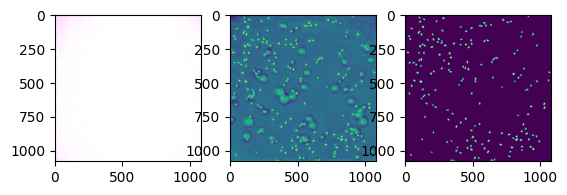

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


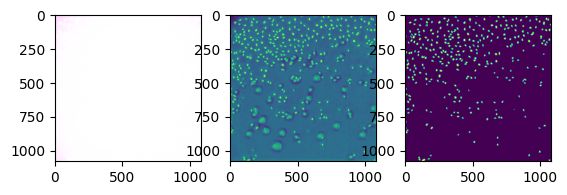

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


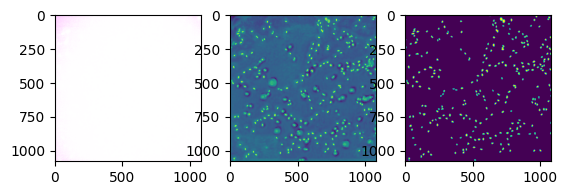

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


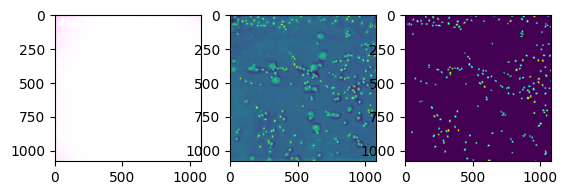

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


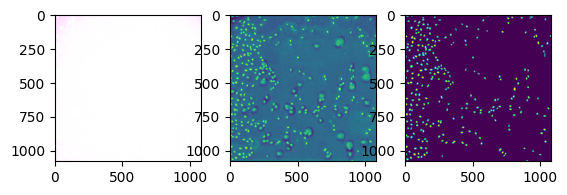

In [143]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.subplot(1,3,1)
    plt.imshow(images[i])
    plt.subplot(1,3,2)
    plt.imshow(cellprobs[i])
    plt.subplot(1,3,3,)
    plt.imshow(masks[i])
    plt.show()

#plt.imshow(flows[0][3][:,:,0])